# Plots

Generating plots for presentation at the Society for the Neurobiology of Language Annual Meeting, 2023

### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# import seaborn as sns
from scipy.stats import pearsonr, zscore
from itertools import repeat, chain
from brainiak.eventseg.event import EventSegment

### Random matrices

In [ ]:
for i in range(5):
    X = np.random.uniform(0, 5, size=(10, 10))
    np.fill_diagonal(X, 0)
    plt.imshow(X)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"matrix{i}.png", dpi=300)

### Simple example of windowed dynamic connectivity

Create timeseries

In [3]:
timpts= 100
voxels = 3
timeseries = np.zeros((voxels, timpts))

for i in range(len(timeseries)):
    timeseries[i, :] = np.random.uniform(0.1, 0.2, timpts)

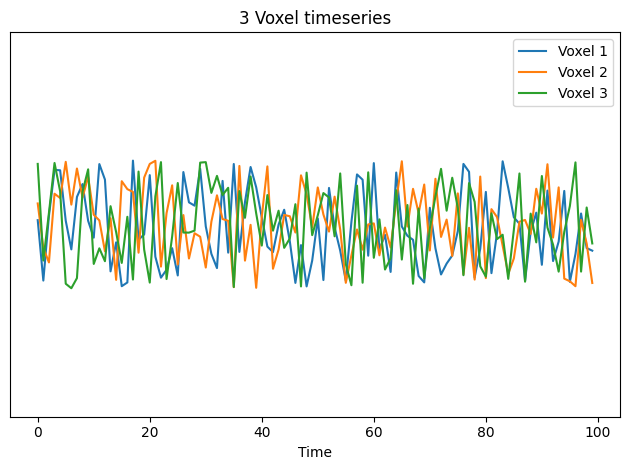

In [4]:
for i in range(voxels):
    plt.plot(timeseries[i, :]);

plt.ylim(0, 0.3)
plt.yticks([])

plt.title('3 Voxel timeseries')
plt.legend(['Voxel 1', 'Voxel 2', 'Voxel 3'])
plt.xlabel('Time')
plt.tight_layout()

Calculate correlations

In [5]:
t = 100
k = 25

# empty object to store correlation matrices for later
corr_obj = []

for l in range(0, t-k+1, k):
    end = l+k
    window = timeseries[:, l:end]

    # get pearson R for each voxel
    corrs = np.zeros((voxels, voxels))
    for i in range(voxels):
        for j in range(voxels):
            r, _ = pearsonr(window[i], window[j])
            corrs[i, j] = r

    corr_obj.append(corrs)

Plot timeseris and correlations together

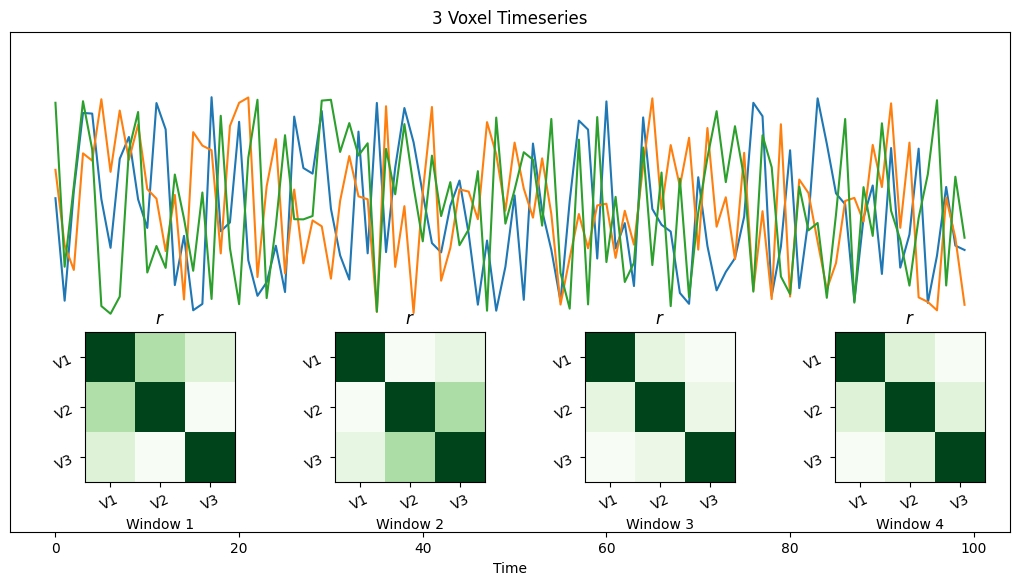

In [13]:
# create figure and axes
fig = plt.figure(figsize=(10, 5))
axes = fig.add_axes([0, 0, 1, 1])

#set labels and other stuff
axes.set_xlabel('Time')
axes.set_yticks([])
axes.set_title('3 Voxel Timeseries')
axes.set_ylim(0, 0.23)

# plot timeseries
for i in range(voxels):
    axes.plot(timeseries[i, :]);

titles = ['Window 1', 'Window 2', 'Window 3', 'Window 4']
x_pos = [0, 0.25, 0.5, 0.75]

# add windows
for i in range(4):
    axes2 = fig.add_axes([x_pos[i], 0.1, 0.3, 0.3])
    axes2.imshow(corr_obj[i], cmap='Greens')
    axes2.set_yticks([0, 1, 2]) 
    axes2.set_yticklabels(['V1', 'V2', 'V3'], rotation=25)
    axes2.set_xticks([0, 1, 2])
    axes2.set_xticklabels(['V1', 'V2', 'V3'], rotation=25)
    axes2.set_xlabel(titles[i])
    axes2.set_title(f'$r$')

# save
fig.savefig('windows.png', dpi=300, bbox_inches='tight')

### Estimating window length

Function for swc

In [15]:
# import numpy as np

def swc_loop(x, y, delta, TR):
    h = 2 * delta * TR
    r = np.zeros((len(x)))

    for n in range(delta, (len(x) - delta)):
        a = n - delta
        b = n + delta
        r[n] = (TR / h) * np.sum((x[a:b] * y[a:b]) - (np.mean(x[a:b]) * np.mean(y[a:b])))

    return r, float(h)

some variables we will need

In [16]:
Hz = 0.025
nt = 120
w = 2 * np.pi * Hz
k = np.arange(nt)
TR = 1.0
theta = np.arccos(.2); # phase difference
r = np.zeros((60, nt))
h = np.zeros((60, 1))
x = np.cos(w * k * TR)
x = x / np.std(x)
y = np.cos(w * k * TR  + theta)
y = y / np.std(y)

executing the swc function

In [17]:
for delta in range(1, 61):
    r[delta-1, :], h[delta-1] = swc_loop(x.flatten(), y.flatten(), delta, TR)

h = np.tile(h, (1, nt))
z = r != 0

plot

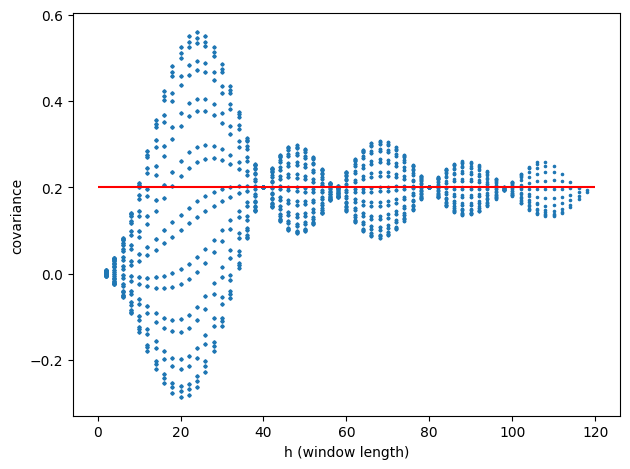

In [18]:
plt.scatter(h[z], r[z], s=10, marker='.')
plt.hlines(y=0.2, xmin=0, xmax=120, colors='red')
plt.xlabel('h (window length)')
plt.ylabel('covariance')
plt.tight_layout()
# plt.savefig("covariance.png", dpi = 300)

### Hidden markov model

Function for generating timeseries with obvious events

In [4]:
def sim_data(n_events, noise, n_voxels, plot=False, skew=False):

    labels=[]
    if skew is False:
        for i in range(n_events):
            x = list(repeat(i, 5))
            labels.append(x)
    elif skew is True:
        _l = np.arange(0, n_events)
        x = list(repeat(_l[0], 10))
        labels.append(x)
        for i in range(1, n_events):
            x = list(repeat(i, 5))
            labels.append(x)

    labels = list(chain.from_iterable(labels))
    
    event_blocks = n_events + 1
    pattern = np.random.rand(event_blocks, n_voxels)
    data = np.zeros((len(labels), n_voxels))
    for i in range(len(labels)):
        data[i, :] = pattern[labels[i], :] +\
            noise * np.random.rand(n_voxels)

    if plot == True:
        plt.imshow(zscore(data.T), origin='lower')
        plt.xlabel('Time')
        plt.ylabel('Voxels')
        plt.title('Simulated data with events')
        plt.xticks(np.arange(0, data.shape[0], 5))
        boundaries = np.where(np.diff(labels))[0] + 0.5
        for boundary in boundaries:
            plt.axvline(boundary, 0, 1, color='red')

        plt.legend(handles=[plt.Line2D([0], [0], color='red', label='boundary')])
        plt.tight_layout()

    return data, labels

Making the data

In [5]:
X, labels = sim_data(4, noise=0.1, n_voxels=10, plot=False)

Plotting

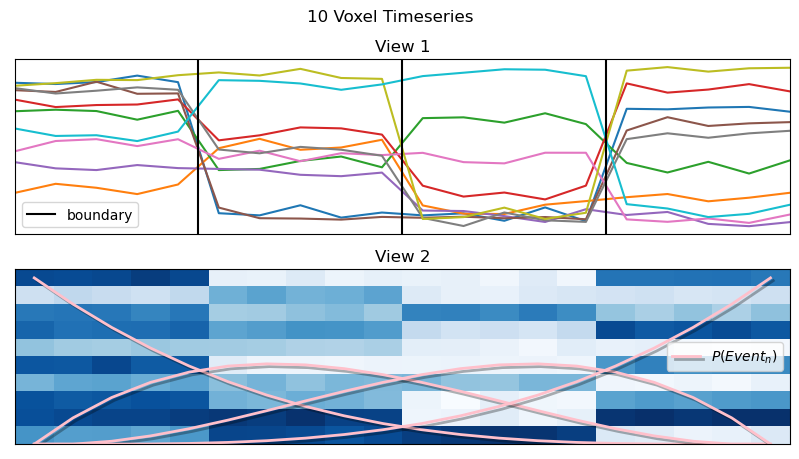

In [60]:
import matplotlib.patheffects as pe


fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))
ax[0].plot(X)
ax[0].set_title('View 1')
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[0].set_xlim((0, 19))
boundaries = np.where(np.diff(labels))[0] + 0.5
for boundary in boundaries:
    ax[0].axvline(boundary, 0, 1, color='k')
ax[0].legend(handles=[plt.Line2D([0], [0], color='k', label='boundary')])

ax[1].imshow(X.T, aspect='auto', cmap='Blues')
ax[1].set_title('View 2')
ax[1].set_yticks([])
ax[1].set_xticks([])

es_prior = EventSegment(4)
prior = es_prior.model_prior(len(labels))[0]
ax[1].plot(9.5 - 9.5 * (prior / np.max(prior)), color='pink', lw=2, path_effects=[pe.SimpleLineShadow(shadow_color='k'), pe.Normal()])
ax[1].legend(handles=[plt.Line2D([0], [0], color='pink', label=f'$P(Event_n)$', lw=2, path_effects=[pe.SimpleLineShadow(shadow_color='k'), pe.Normal()])])


fig.suptitle('10 Voxel Timeseries')

#save figure
fig.savefig('hmmsim.png', dpi=300, bbox_inches='tight')
